In [1]:
import pandas as pd
import numpy as np 

import torch

from dataset import WebcamDataset
from model import CNN_LSTM
from quantile_regression import QuantileRegressionModel
from trainer import Trainer
from torch.utils.data import DataLoader
from plotting import plot_predictions_vs_ground_truth
import matplotlib.pyplot as plt


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
BATCH_SIZE = 32

# Data loading

In [4]:
train_dataset = WebcamDataset(images_path="data/X_BC_train.npy", ghi_values_path="data/labels_train.npy", subset=64)
val_dataset = WebcamDataset(images_path="data/X_BC_val.npy", ghi_values_path="data/labels_val.npy",subset=64)
test_dataset = WebcamDataset(images_path="data/X_BC_test.npy", ghi_values_path="data/labels_test.npy",subset=64)

In [5]:
train_dataset.__len__()

64

# Data visualization

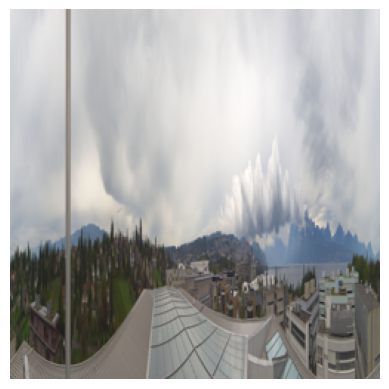

In [6]:
# Get the first image without applying normalization
first_image = train_dataset.images[0]  # Access the raw image before normalization

first_image = first_image.astype(np.uint8)  # Convert to uint8 for display

# Display the image
plt.imshow(first_image)
plt.axis('off')
plt.show()


# Model creation

In [7]:
model = CNN_LSTM()
model = QuantileRegressionModel(model)

# Print the model architecture
print(model)

QuantileRegressionModel(
  (base_model): CNN_LSTM(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (dropout1): Dropout(p=0.3, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
    (lstm1): LSTM(89888, 128, batch_first=True)
    (lstm2): LSTM(128, 64, batch_first=True)
    (fc1): Linear(in_features=64, out_features=64, bias=True)
    (fc2): Linear(in_features=64, out_features=2, bias=True)
  )
)


We now transform it to Bayesian

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Create the Trainer object
trainer = Trainer(model, train_dataset, val_dataset, test_dataset,gpu_id=1, batch_size=BATCH_SIZE, epochs=10, model_snapshot_file="output/test.pt", train_loss_file="output/train_losses.csv", test_loss_file="output/test_losses.csv",quantile_reg=True)

# Start training
trainer.train()

[GPU1] Epoch 0 | Batchsize: 32 | Steps: 2
Epoch 0/10, Train Loss: 104.1329, Processed Train Batches: 2, Skipped Train Batches: 0, Train Time: 3.47s
Sample 1 - Lower: 0.633, Upper: 2.995, Width: 2.362
Sample 2 - Lower: 0.634, Upper: 2.999, Width: 2.365
Epoch 1/10, Validation Loss: 510.1253, Processed Validation Batches: 2, Skipped Validation Batches: 0, Eval Time: 3.56s
[GPU1] Epoch 1 | Batchsize: 32 | Steps: 2
Epoch 1/10, Train Loss: 103.8560, Processed Train Batches: 2, Skipped Train Batches: 0, Train Time: 3.44s
Sample 1 - Lower: 0.785, Upper: 3.334, Width: 2.548
Sample 2 - Lower: 0.786, Upper: 3.338, Width: 2.552
Epoch 2/10, Validation Loss: 509.8328, Processed Validation Batches: 2, Skipped Validation Batches: 0, Eval Time: 3.53s
[GPU1] Epoch 2 | Batchsize: 32 | Steps: 2
Epoch 2/10, Train Loss: 103.5790, Processed Train Batches: 2, Skipped Train Batches: 0, Train Time: 3.92s
Sample 1 - Lower: 0.950, Upper: 3.691, Width: 2.742
Sample 2 - Lower: 0.951, Upper: 3.697, Width: 2.746
Epoc

In [10]:
trainer.evaluate()


(511.32733154296875, 2, 0)

Outputs: [[0.0490384  1.5892789 ]
 [0.0490384  1.5892789 ]
 [0.04903902 1.5892754 ]
 [0.0490385  1.5892782 ]
 [0.04903893 1.5892758 ]]
Labels: [[589.]
 [611.]
 [630.]
 [661.]
 [683.]]


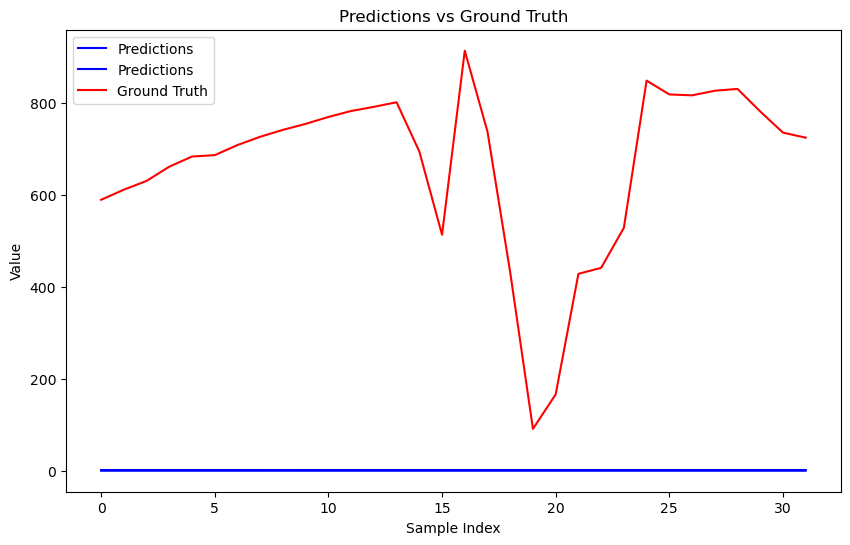

In [11]:
plot_predictions_vs_ground_truth(model, trainer.val_loader, device)
